In [1]:

import importlib
import sys

sys.path.append('./stat-atlas')

Atl = importlib.import_module("stat-atlas.models")
Vis = importlib.import_module("stat-atlas.visualizations")

import load_NWB

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import os 
import pynwb
import remfile 
import h5py

from scipy.io import loadmat
import numpy as np
import os

from pynwb import NWBHDF5IO
import pandas as pd
import h5py
from dandi.dandiapi import DandiAPIClient
import remfile

from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
#from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
#from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
#from pynwb.core import NWBDataInterface
#from pynwb.epoch import TimeIntervals
#from pynwb.behavior import SpatialSeries, Position
#from pynwb.image import ImageSeries


#from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries



In [2]:
datapath = '/Users/danielysprague/foco_lab/data' #change to where you store data on your local drive

In [3]:
#Skip files that are too bent or have other issues
skip_files = ['20231013-9-30-0', '20230412-20-15-17', '2023-01-23-01', '20239828-11-14-0', '2023-01-05-01', '2023-01-10-14', '2022-06-28-07', '2022-07-26-01', '2023-01-19-15', '2022-07-15-06', '2022-08-02-01', '2023-01-09-08', '2023-01-09-28', '2023-01-10-14', '2023-01-17-14', '2023-01-19-22', '2023-01-23-01']

In [4]:
import pickle

# Code below used to generate group assignments for 5-fold cross validation. You can ignore this block and just load the group assignments in the next cell.


'''
#folders = ['NP_nwb', 'NWB_chaudhary']
folders = ['NP_og', 'HL', 'EY', 'SK2', 'SK1', 'KK', 'SF']
file_names = []
groups = []

for folder in folders:
    i=0
    for file in os.listdir(datapath + '/final_NWB/'+folder):
        if folder == 'NP_og':
            if file[:-4] in skip_files:
                continue
            file_names.append(file[:-4])
            groups.append('original')
        elif file[-4:] == '.nwb':
            if file[:4] in skip_files:
                continue
            file_names.append(file[:-4])
            groups.append(i%5)
            i+=1
i=0
for file in os.listdir(datapath + '/Kimura_images'):
    if file[-4:] == '.mat':
        if file[:4] in skip_files:
                continue
        file_names.append(file[:-4])
        groups.append(i%5)
        i+=1

for file in os.listdir(datapath + '/NP_nwb'):
    if file[-4:] == '.nwb':
        if file[:4] in skip_files:
                continue
        file_names.append(file[:-4])
        groups.append('original')
file_groups = {}

for i, key in enumerate(file_names):
    file_groups[key] = groups[i]


with open('/Users/danielysprague/foco_lab/NWBelegans/StatAtlas/group_assigns.pkl', 'wb') as f:
    pickle.dump(file_groups, f)

'''

"\n#folders = ['NP_nwb', 'NWB_chaudhary']\nfolders = ['NP_og', 'HL', 'EY', 'SK2', 'SK1', 'KK', 'SF']\nfile_names = []\ngroups = []\n\nfor folder in folders:\n    i=0\n    for file in os.listdir(datapath + '/final_NWB/'+folder):\n        if folder == 'NP_og':\n            if file[:-4] in skip_files:\n                continue\n            file_names.append(file[:-4])\n            groups.append('original')\n        elif file[-4:] == '.nwb':\n            if file[:4] in skip_files:\n                continue\n            file_names.append(file[:-4])\n            groups.append(i%5)\n            i+=1\ni=0\nfor file in os.listdir(datapath + '/Kimura_images'):\n    if file[-4:] == '.mat':\n        if file[:4] in skip_files:\n                continue\n        file_names.append(file[:-4])\n        groups.append(i%5)\n        i+=1\n\nfor file in os.listdir(datapath + '/NP_nwb'):\n    if file[-4:] == '.nwb':\n        if file[:4] in skip_files:\n                continue\n        file_names.append(fil

### Create atlas with training and testing split by group

In [44]:
splits = {'train':[], 'validation':[], 'test':[]}
splits_df = pd.DataFrame(columns=['Filename', 'Group', 'Dataset'])
i=0

for file in os.listdir('/Users/danielysprague/foco_lab/data/aligned_2024_05_01/aligned_full'):
    if file == '.DS_Store':
        continue
    
    group = i%10

    filenwb = file[:-4]+'.nwb'

    dataset = ''

    if filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/EY'):
        dataset = 'EY'
    elif filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/HL'):
        dataset = 'HL'
    elif filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/KK'):
        dataset = 'KK'
    elif filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/NP_og'):
        dataset = 'NP'
    elif filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/SF'):
        dataset = 'SF'
    elif filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/SK1'):
        dataset = 'SK1'
    elif filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/SK2'):
        dataset = 'SK2'


    if group == 0:
        splits['test'].append(file[:-4])
        splits_df.loc[len(splits_df)] = {'Filename':file[:-4], 'Group':'test', 'Dataset':dataset}

    elif group == 1:
        splits['validation'].append(file[:-4])
        splits_df.loc[len(splits_df)] = {'Filename':file[:-4], 'Group':'validation', 'Dataset':dataset}

    else:
        splits['train'].append(file[:-4])
        splits_df.loc[len(splits_df)] = {'Filename':file[:-4], 'Group':'train', 'Dataset':dataset}

    i+=1

print(splits)
print(len(splits['train']))
print(len(splits['validation']))
print(len(splits['test']))

splits_df.to_csv('/Users/danielysprague/foco_lab/fDNC_Neuron_ID/Data/tr_te_val_splits.csv')
    
print(splits_df)
    

{'train': ['2022-12-21-06', '20221106-21-00-09', '20230322-20-16-50', '5', '2023-01-06-08', '4', '20230918-17-21-0', '2021-12-03-w00-NP1', '20230506-12-56-00', '20230506-14-24-57', '1', '38_YAaDV', '2023-01-16-08', '20230510-13-25-46', '56_YAaDV', '20190928_08', '2', '2023-01-13-07', '20191104_10', '20190929_06', '20230928-14-27-0', '64_YAaDV', '2023-01-23-15', '20190929_07', '20190929_05', '2022-03-05-w00-NP1', '20190925_04', '11_YAaLR', '76_YAaDV', '2022-07-15-12', '20191030_07', '20190925_01', '2023-01-09-15', '20190929_03', '20231013-11-11-0', '20190929_02', '20221028-18-48-00', '2023-01-19-08', '2023-01-23-21', '2022-02-12-w01-NP1', '2023-01-23-08', '2023-01-10-07', '20221215-20-02-49', '2022-06-14-01', '2022-02-11-w03-NP1', '20230904-15-09-05', '20230928-16-0-0', '20230510-15-49-47', '20191104_08', '2022-02-12-w00-NP1', '2022-06-14-07', '2022-06-14-13', '20230506-15-33-51', '20230322-18-57-04', '2022-06-28-01', '20_YAaLR', '20230904-15-59-40', '20230918-13-21-0', '20190928_05', '

In [45]:
with open('./data/group_assigns.pkl', 'rb') as f:
    group_assigns = pickle.load(f)

In [50]:
group_df = pd.DataFrame(columns=['Filename', 'Group', 'Dataset', 'ID_skip'])

for key, value in group_assigns.items():

    filenwb = key+'.nwb'

    dataset = ''

    if filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/EY'):
        dataset = 'EY'
    elif filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/HL'):
        dataset = 'HL'
    elif filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/KK'):
        dataset = 'KK'
    elif filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/NP_og'):
        dataset = 'NP_og'
    elif filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/SF'):
        dataset = 'SF'
    elif filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/SK1'):
        dataset = 'SK1'
    elif filenwb in os.listdir('/Users/danielysprague/foco_lab/data/final_nwb/SK2'):
        dataset = 'SK2'

    if key[-5:] == 'YApLR' or key[-5:] == 'YApDV':
        continue

    if key in skip_files:
        ID_skip = True

    else:
        ID_skip = False

    group_df.loc[len(group_df)] = [key, value, dataset, ID_skip]

group_df.to_csv('/Users/danielysprague/foco_lab/data/group_assigns.csv')

In [46]:
group_assigns

{'55_YApDV': 'original',
 '56_YAaDV': 'original',
 '38_YAaDV': 'original',
 '70_YApLR': 'original',
 '20_YApLR': 'original',
 '62_YApLR': 'original',
 '7_YApLR': 'original',
 '76_YAaDV': 'original',
 '11_YAaLR': 'original',
 '64_YAaDV': 'original',
 '76_YApDV': 'original',
 '11_YApLR': 'original',
 '64_YApDV': 'original',
 '70_YAaLR': 'original',
 '56_YApDV': 'original',
 '38_YApDV': 'original',
 '55_YAaDV': 'original',
 '7_YAaLR': 'original',
 '62_YAaLR': 'original',
 '20_YAaLR': 'original',
 '2': 0,
 '3': 1,
 '1': 2,
 '4': 3,
 '5': 4,
 '7': 0,
 '6': 1,
 '8': 2,
 '9': 3,
 '20190928_08': 0,
 '20190929_02': 1,
 '20190929_03': 2,
 '20190925_01': 3,
 '20191030_07': 4,
 '20190925_04': 0,
 '20191030_03': 1,
 '20190929_05': 2,
 '20190929_07': 3,
 '20190929_06': 4,
 '20191104_10': 0,
 '20191104_08': 1,
 '20190924_01': 2,
 '20190928_01': 3,
 '20190928_03': 4,
 '20190924_03': 0,
 '20190924_02': 1,
 '20190928_13': 2,
 '20190928_07': 3,
 '20190928_11': 4,
 '20190928_05': 0,
 '2021-12-03-w00-NP1':

In [10]:
len(group_assigns.keys())

128

In [24]:
group5 = [file for file in group_assigns.keys() if group_assigns[file]==4]

In [1]:
len(group5)

NameError: name 'group5' is not defined

In [7]:
bodypart    = 'head'
path = datapath + '/final_nwb'
#Some datasets are manually cropped so that we are looking at roughly the same area of the head across all images. You can specify a crop file for each dataset here. This should be formatted as a dictionary with the filenames as keys and a two element list of [start x, end x] as the values.
crop_dict = {'SK1': './data/SK1_crop.pkl'} 
folders = ['NP_og', 'HL', 'EY', 'SK2', 'SK1', 'dandi:000776', 'dandi:000692'] # replace with dandi IDs for datasets that you do not have downloaded locally
base_align = [True, False, False, False, False, False, False] #If True, worms in dataset will be considered for use in the initial spatial alignment
ims_unmatched, filenames_unmatched, group_unmatched, base_align_unmatched = load_NWB.load_NWB(path, folders, base_align, group_assigns, bodypart=bodypart, histmatched=False, crop=crop_dict, skipfiles=skip_files)

56_YAaDV.nwb
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


38_YAaDV.nwb
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


.DS_Store
76_YAaDV.nwb
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


11_YAaLR.nwb
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


64_YAaDV.nwb
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


70_YAaLR.nwb
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


55_YAaDV.nwb
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


7_YAaLR.nwb
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


62_YAaLR.nwb
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20_YAaLR.nwb
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2.nwb
not matched
3.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
1.nwb
not matched
.DS_Store
4.nwb
not matched
5.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
7.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
6.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
8.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
9.nwb
not matched
20190928_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190929_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190929_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190925_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20191030_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190925_04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20191030_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190929_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190929_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190929_06.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20191104_10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20191104_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190924_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190928_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190928_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190924_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190924_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190928_13.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190928_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190928_11.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20190928_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
2021-12-03-w00-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
2022-03-05-w00-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
2022-02-12-w00-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
2022-02-22-w04-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
2022-02-11-w03-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
2022-02-12-w01-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
2022-01-22-w04-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
2022-04-26-w01-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
2022-04-26-w00-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
2022-04-01-w00-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230412-20-15-17.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20230506-14-24-57.nwb
not matched
20230510-13-25-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230322-22-43-03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20221106-21-47-31.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230506-12-56-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
.DS_Store
20221106-21-00-09.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230322-20-16-50.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20221028-18-48-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230506-15-33-51.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230510-15-49-47.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230904-15-09-05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20221215-20-02-49.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230909-16-48-09.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230904-14-30-52.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230322-21-41-10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20221106-21-23-19.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230506-15-01-45.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230510-12-53-34.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230904-15-59-40.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched
20230322-18-57-04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


not matched


A newer version (0.62.0) of dandi/dandi-cli is available. You are using 0.61.2
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2022-06-14-07
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2022-06-14-13
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2022-06-28-07
2022-06-28-01
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2022-06-14-01
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2022-07-15-06
2022-07-15-12
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2022-07-20-01
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2022-08-02-01
2022-07-26-01
2022-12-21-06
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-05-01
2023-01-05-18
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-06-01
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-06-08
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-09-08
2023-01-09-15
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-09-22
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-10-07
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-09-28
2023-01-10-14
2023-01-13-07
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-16-01
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-16-22
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-16-08
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-16-15
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-17-01
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-17-07
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-17-14
2023-01-18-01
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-19-15
2023-01-19-08
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-19-22
2023-01-23-01
2023-01-23-08
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-23-15
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-01-23-21
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2023-03-07-01
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20230918-9-54-0
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20230928-14-27-0
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20230928-11-14-0
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20230918-13-21-0
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20230918-17-21-0
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20231013-9-30-0
20230928-16-0-0
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20231013-13-28-0
not matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20231013-11-11-0
not matched


In [5]:
bodypart    = 'head'
path = datapath + '/final_nwb'
#Some datasets are manually cropped so that we are looking at roughly the same area of the head across all images. You can specify a crop file for each dataset here. This should be formatted as a dictionary with the filenames as keys and a two element list of [start x, end x] as the values.
crop_dict = {'SK1': './data/SK1_crop.pkl'} 
folders = ['NP_og', 'HL', 'EY', 'SK2', 'SK1', 'dandi:000776', 'dandi:000692'] # replace with dandi IDs for datasets that you do not have downloaded locally
base_align = [True, False, False, False, False, False, False] #If True, worms in dataset will be considered for use in the initial spatial alignment
ims_matched, filenames_matched, group_matched, base_align_matched = load_NWB.load_NWB(path, folders, base_align, group_assigns, bodypart=bodypart, crop=crop_dict, skipfiles=skip_files) # Takes ~twice as long with matching

56_YAaDV.nwb
matched
38_YAaDV.nwb
matched
.DS_Store
76_YAaDV.nwb
matched
11_YAaLR.nwb
matched
64_YAaDV.nwb
matched
70_YAaLR.nwb
matched
55_YAaDV.nwb
matched
7_YAaLR.nwb
matched
62_YAaLR.nwb
matched
20_YAaLR.nwb
matched
2.nwb
matched
3.nwb
matched
1.nwb
matched
.DS_Store
4.nwb
matched
5.nwb
matched
7.nwb
matched
6.nwb
matched
8.nwb
matched
9.nwb
matched
20190928_08.nwb
matched
20190929_02.nwb
matched
20190929_03.nwb
matched
20190925_01.nwb
matched
20191030_07.nwb
matched
20190925_04.nwb
matched
20191030_03.nwb
matched
20190929_05.nwb
matched
20190929_07.nwb
matched
20190929_06.nwb
matched
20191104_10.nwb
matched
20191104_08.nwb
matched
20190924_01.nwb
matched
20190928_01.nwb
matched
20190928_03.nwb
matched
20190924_03.nwb
matched
20190924_02.nwb
matched
20190928_13.nwb
matched
20190928_07.nwb
matched
20190928_11.nwb
matched
20190928_05.nwb
matched
2021-12-03-w00-NP1.nwb
matched
2022-03-05-w00-NP1.nwb
matched
2022-02-12-w00-NP1.nwb
matched
2022-02-22-w04-NP1.nwb
matched
2022-02-11-w03-NP

In [8]:
def train_split_atlas(ims, filenames, groups, to_match, atlas_path, aligned_path, description = ''):

    ims_dict = [{'index':i,'file':filenames[i], 'group':groups[i], 'im':ims[i], 'to_match':to_match[i]} for i in range(len(ims))]

    im1 = [im_dict['im'] for im_dict in ims_dict if im_dict['group']==0]
    im1_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['group']==0]
    im2 = [im_dict['im'] for im_dict in ims_dict if im_dict['group']==1]
    im2_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['group']==1]
    im3 = [im_dict['im'] for im_dict in ims_dict if im_dict['group']==2]
    im3_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['group']==2]
    im4 = [im_dict['im'] for im_dict in ims_dict if im_dict['group']==3]
    im4_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['group']==3]
    im5 = [im_dict['im'] for im_dict in ims_dict if im_dict['group']==4]
    im5_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['group']==4]
    imoriginal = [im_dict['im'] for im_dict in ims_dict if im_dict['group']=='original']
    imoriginal_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['group']=='original']

    im_groups = [im1,im2,im3,im4,im5, imoriginal]
    im_match_groups = [im1_match,im2_match,im3_match,im4_match,im5_match, imoriginal_match]

    for i in range(5):
        im_test = im_groups[i]
        im_train = [im_groups[j] for j,im in enumerate(im_groups) if j!=i]
        im_train_match = [im_match_groups[j] for j, im in enumerate(im_groups) if j!=i]
        im_train = sum(im_train,[])
        im_train_match = sum(im_train_match, [])
        im_total = im_train+im_test

        #match_indexes = [j for j, im in enumerate(im_train) if im.match==True]
        match_indexes = [j for j in range(len(im_train_match)) if im_train_match[j]==True]

        bodypart='head'

        Atlas = Atl.Atlas()

        trained_atlas, aligned, params, cost, counts = Atlas.train_atlas(im_total, bodypart, match_indices=match_indexes, train_indices=range(len(im_train))) # Train atlas on the sample worms
        aligned_atlas, final_aligned, params = Vis.major_axis_align(trained_atlas, aligned, params, shift=10)

        aligned_atlas['description'] = 'Atlas trained using all data from NP orginal, Yemini 21, Foco, Ray, Chaudhary, Kimura, and Flavell datasets excluding group ' +str(i) +'. Histogram matched, Z-scored, and median sampled' #Change when updating

        with open(atlas_path+ 'exgroup'+ str(i) +'.pkl', 'wb') as f: #Change when updating
            pickle.dump(aligned_atlas, f)
                
        for k in range(len(im_train),len(im_total)):
            filename = filenames[k]

            pos = im_total[k].get_positions()
            col = im_total[k].get_colors_readout()
            labels = np.transpose(np.asarray(im_total[k].get_annotations()))

            beta = params['beta'][:,:,k]
            beta0 = params['beta0'][:,:,k]

            xyzrgb = np.hstack((pos,col))

            #alignedxyzrgb = aligned[i]
            alignedxyzrgb = xyzrgb@beta+beta0

            alignedxyzrgb = alignedxyzrgb.astype(float)

            alignedxyzrgb[:,3:] = col

            data = np.hstack((xyzrgb, alignedxyzrgb, np.expand_dims(labels,axis=1)))

            df = pd.DataFrame(data, columns=['real_X','real_Y','real_Z', 'real_R', 'real_G', 'real_B','aligned_x','aligned_y','aligned_z', 'aligned_R','aligned_G', 'aligned_B', 'ID'])

            df.to_csv(aligned_path + 'group'+str(i+1)+'/'+filename+'.csv')

#train_split_atlas(ims_test_unmatch, atlas_path = '/Users/danielysprague/foco_lab/data/atlases/test_unmatch/', aligned_path = '/Users/danielysprague/foco_lab/data/aligned_test_unmatch/', description = 'Trained using all datasets. Hist matched, Z-scored, median sampled')
#train_split_atlas(ims_test, atlas_path = '/Users/danielysprague/foco_lab/data/atlases/test/', aligned_path = '/Users/danielysprague/foco_lab/data/aligned_test/', description = 'Trained using all datasets. Hist matched, Z-scored, median sampled')
train_split_atlas(ims_matched, filenames_matched, group_matched, base_align_matched, datapath + '/atlases/2024_05_01_split/', datapath + '/aligned_2024_05_01/aligned_split/', description = 'Trained using all datasets. Fixed hist matched, Z-scored, median sampled. Only initializing alignment for non-training set')
train_split_atlas(ims_unmatched, filenames_unmatched, group_unmatched, base_align_unmatched, datapath + '/atlases/2024_05_01_split_unmatch/', datapath + '/aligned_2024_05_01/aligned_split_nomatch/', description = 'Trained using all datasets. Non-matched, Z-scored, median sampled. Only initializing alignment for non-training set')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
annotations = [x.get_annotations() for x in ims_matched]
N = list(set([item for sublist in annotations for item in sublist]))
print(N)

['', 'RMDL', 'ADFR', 'AWBL', 'URYDL', 'SAADR', 'RIS', 'AVHL', 'OLLR', 'AWCL', 'RICR', 'I6', 'IL1DR', 'SIBDL', 'AIYR', 'OLQVL', 'MI', 'IL2DR', 'SIBVL', 'NSML', 'RMDVL', 'RMDDL', 'AIML', 'AVBR', 'RIVR', 'CEPDR', 'SAAVR', 'RIFR', 'URBR', 'IL1R', 'IL1DL', 'URXL', 'NSMR', 'M2R', 'M3L', 'OLQVR', 'AVFR', 'AIMR', 'RMED', 'AVDR', 'RMHL', 'SABVL', 'CEPVL', 'URADL', 'ADAL', 'ALA', 'RMDVR', 'RMDR', 'ASIR', 'AVAR', 'AIYL', 'VB2', 'URYDR', 'RIPR', 'RMEV', 'URYVR', 'I2R', 'OLQDL', 'IL2VL', 'VA2', 'MCR', 'AFDL', 'I3', 'AINR', 'RIR', 'AVFL', 'VB02', 'AMSOL', 'RIGL', 'AVJL', 'I1L', 'SMBVR', 'M5', 'AIBR', 'IL2R', 'SIADL', 'ASHR', 'RIFL', 'RMDD', 'AS1', 'RID', 'RMDDR', 'URYVL', 'AWBR', 'CEPVR', 'ASEL', 'VB3', 'AWCR', 'SAAVL', 'ASJR', 'URXR', 'IL1VR', 'ASIL', 'OLQDR', 'AWAR', 'RIML', 'AFDR', 'VD1', 'ADLR', 'RMFL', 'AWAL', 'ADAR', 'RMFR', 'AVDL', 'AVER', 'M4', 'RMGR', 'RMER', 'RIBL', 'RIAR', 'RIAL', 'DB2', 'VA1', 'SIBDR', 'AINL', 'BAGR', 'I4', 'I2L', 'M1', 'AIZL', 'AVAL', 'AIM', 'SMDVR', 'RMGL', 'AIAL', 'SA

In [12]:
def train_NP_atlas(ims, match, filenames, atlas_path, aligned_path, train_indices=None, description=''):

    match_indexes = [j for j, im in enumerate(ims) if match[j]==True]

    if train_indices is None:
        train_indices = match_indexes

    Atlas = Atl.Atlas()

    trained_atlas, aligned, params, cost, counts = Atlas.train_atlas(ims, bodypart, match_indices=match_indexes, train_indices=train_indices) # Train atlas on the sample worms
    aligned_atlas, final_aligned, params = Vis.major_axis_align(trained_atlas, aligned, params, shift=10)
    
    aligned_atlas['description'] = 'description'

    with open(atlas_path, 'wb') as f:
        pickle.dump(aligned_atlas, f)

    for k in range(len(ims)):
        filename = filenames[k]

        pos = ims[k].get_positions()
        col = ims[k].get_colors_readout()
        labels = np.transpose(np.asarray(ims[k].get_annotations()))

        beta = params['beta'][:,:,k]
        beta0 = params['beta0'][:,:,k]

        xyzrgb = np.hstack((pos,col))

        #alignedxyzrgb = aligned[i]
        alignedxyzrgb = xyzrgb@beta+beta0

        alignedxyzrgb = alignedxyzrgb.astype(float)

        alignedxyzrgb[:,3:] = col

        data = np.hstack((xyzrgb, alignedxyzrgb, np.expand_dims(labels,axis=1)))

        df = pd.DataFrame(data, columns=['real_X','real_Y','real_Z', 'real_R', 'real_G', 'real_B','aligned_x','aligned_y','aligned_z', 'aligned_R','aligned_G', 'aligned_B', 'ID'])

        df.to_csv(aligned_path+filename+'.csv')

    return aligned_atlas, final_aligned

#aligned_NP_match, final_NP_match = train_full_atlas(ims_test_unmatch, '/Users/danielysprague/foco_lab/data/atlases/test.pkl', '/Users/danielysprague/foco_lab/data/aligned_test/', train_indices = None, description = 'Atlas trained on only NP data')
aligned_NP_match, final_NP_match = train_NP_atlas(ims_matched, base_align_matched, filenames_matched,datapath + '/atlases/2024_05_01_NPonly.pkl', datapath + '/aligned_2024_05_01/aligned_NP/', train_indices = None, description = 'Atlas trained on only NP data')
aligned_NP_nomatch, final_NP_nomatch = train_NP_atlas(ims_unmatched, base_align_unmatched, filenames_unmatched,datapath + '/atlases/2024_05_01_NPunmatch.pkl', datapath + '/aligned_2024_05_01/aligned_NP_nomatch/', train_indices = None, description = 'Atlas trained on only NP data')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

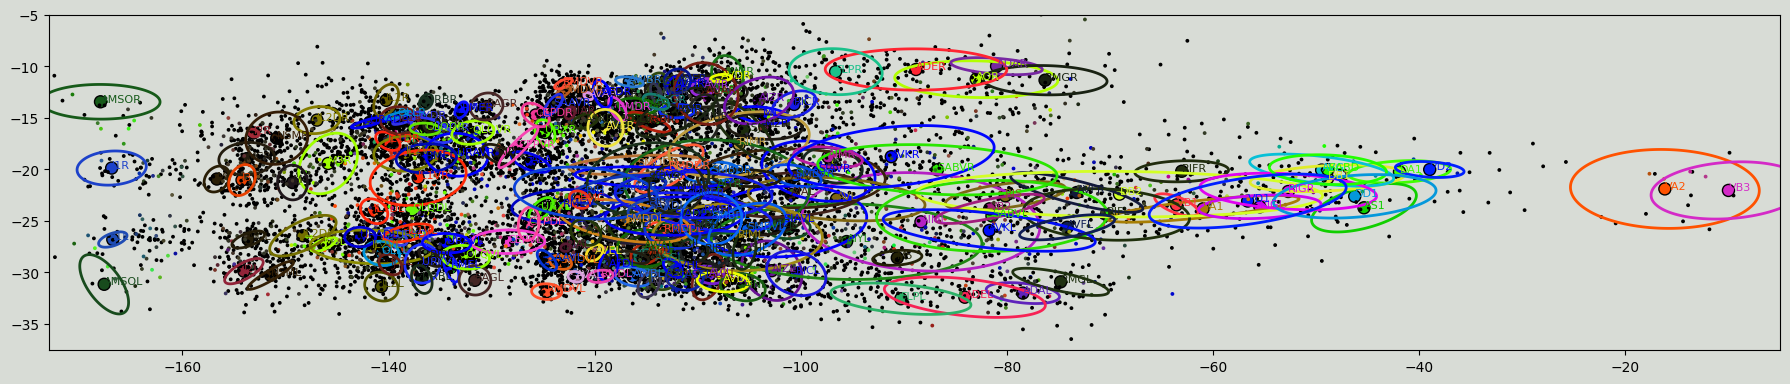

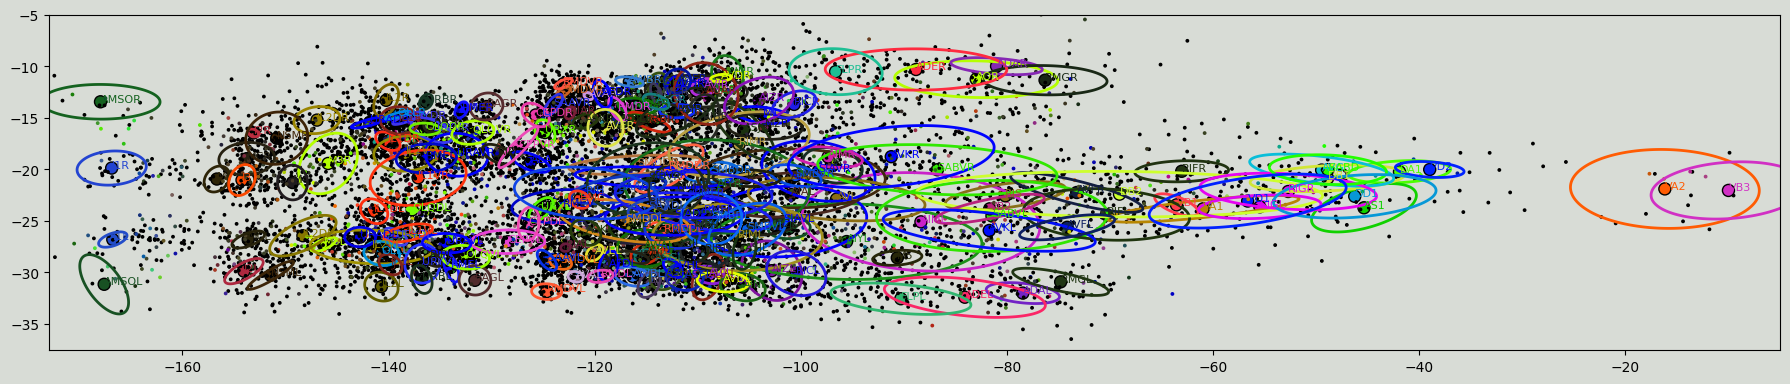

In [ ]:
Vis.visualize_pretty(aligned_NP_match, final_NP_match, '')
Vis.visualize_pretty(aligned_NP_nomatch, final_NP_nomatch, '')

In [13]:
def train_NP_split_atlas(ims, filenames, atlas_path, aligned_path, description=''):

    for i, im in enumerate(ims):
        match_indices = [j for j, im_train in enumerate(ims) if i!=j]
        train_indices = match_indices

        filename = filenames[i]

        Atlas = Atl.Atlas()

        trained_atlas, aligned, params, cost, counts = Atlas.train_atlas(ims, bodypart, match_indices=match_indices, train_indices=train_indices) # Train atlas on the sample worms
        aligned_atlas, final_aligned, params = Vis.major_axis_align(trained_atlas, aligned, params, shift=10)
        
        aligned_atlas['description'] = description

        with open(atlas_path +'ex'+filename+'.pkl', 'wb') as f:
            pickle.dump(aligned_atlas, f)

        pos = im.get_positions()
        col = im.get_colors_readout()
        labels = np.transpose(np.asarray(im.get_annotations()))

        beta = params['beta'][:,:,i]
        beta0 = params['beta0'][:,:,i]

        xyzrgb = np.hstack((pos,col))

        #alignedxyzrgb = aligned[i]
        alignedxyzrgb = xyzrgb@beta+beta0

        alignedxyzrgb = alignedxyzrgb.astype(float)

        alignedxyzrgb[:,3:] = col

        data = np.hstack((xyzrgb, alignedxyzrgb, np.expand_dims(labels,axis=1)))

        df = pd.DataFrame(data, columns=['real_X','real_Y','real_Z', 'real_R', 'real_G', 'real_B','aligned_x','aligned_y','aligned_z', 'aligned_R','aligned_G', 'aligned_B', 'ID'])

        df.to_csv(aligned_path+filename+'.csv')

    return aligned_atlas, final_aligned


aligned_NP_match, final_NP_match = train_NP_split_atlas(ims_unmatched[0:10],filenames_unmatched[0:10], datapath + '/atlases/2024_05_01_NP_split/', datapath + '/aligned_2024_05_01/aligned_NP_split/', description = 'Atlas trained on only NP data, leave-one-out')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

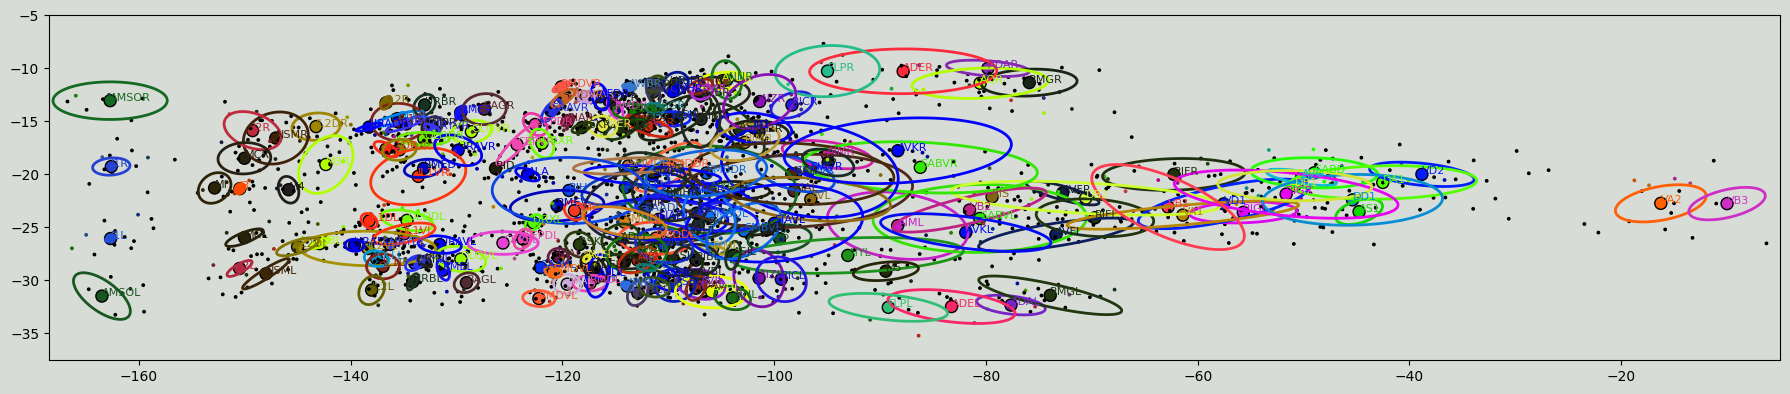

In [14]:
Vis.visualize_pretty(aligned_NP_match, final_NP_match, '')

### Create full dataset atlas and run alignment with NeuroPAL atlas

  0%|          | 0/10 [00:00<?, ?it/s]

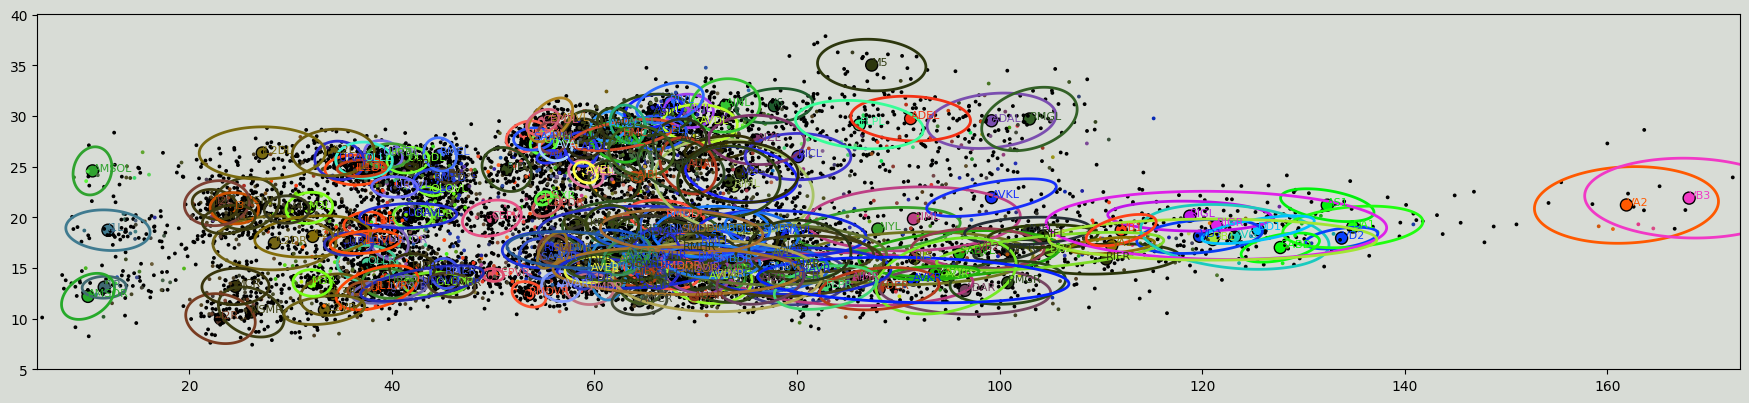

In [15]:
'''
Train atlas on all datasets.

Currently implemented by passing in all ims that you want aligned to the atlas.

Match_indexes determines which datasets are candidates for the match initialization. This should not affect the final outcome,
but some errors occurred when less labeled datasets were included here. This is currently set to only include the first 10 datasets
in ims, which are the original 10 NeuroPAL datasets.

Train_indices determiens which datasets are used to train the atlas. All datasets will be aligned to the atlas, but only datasets included
in train_indices will be used to update the atlas means and covariances. Here this just includes all datasets.
'''

match_indices = [j for j, match in enumerate(base_align_matched) if match==True]

Atlas = Atl.Atlas()

trained_atlas_full, aligned_full, params_full, cost, counts = Atlas.train_atlas(ims_matched, bodypart, match_indices=match_indices, train_indices=range(len(ims_matched))) # Train atlas on the sample worms
aligned_atlas_full, final_aligned_full, params_full = Vis.major_axis_align(trained_atlas_full, aligned_full, params_full, shift=10)
Vis.visualize_pretty(aligned_atlas_full,final_aligned_full,'')

In [16]:
import pickle 

'''
Save atlas named with date of run and add description of what is included in the atlas.
'''

aligned_atlas_full['description'] = 'Atlas trained using all data from NP orginal, Yemini 21, Foco, Ray, Chaudhary, Kimura datasets, Flavell. Histogram matched, Z-scored, and median sampled'

with open(datapath + '/atlases/2024_05_01_match_full_nosplit.pkl', 'wb') as f:
    pickle.dump(aligned_atlas_full, f)

for k in range(len(ims_matched)):
    filename = filenames_matched[k]

    pos = ims_matched[k].get_positions()
    col = ims_matched[k].get_colors_readout()
    labels = np.transpose(np.asarray(ims_matched[k].get_annotations()))

    beta = params_full['beta'][:,:,k]
    beta0 = params_full['beta0'][:,:,k]

    xyzrgb = np.hstack((pos,col))

    #alignedxyzrgb = aligned[i]
    alignedxyzrgb = xyzrgb@beta+beta0

    alignedxyzrgb = alignedxyzrgb.astype(float)

    alignedxyzrgb[:,3:] = col

    data = np.hstack((xyzrgb, alignedxyzrgb, np.expand_dims(labels,axis=1)))

    df = pd.DataFrame(data, columns=['real_X','real_Y','real_Z', 'real_R', 'real_G', 'real_B','aligned_x','aligned_y','aligned_z', 'aligned_R','aligned_G', 'aligned_B', 'ID'])

    df.to_csv(datapath + '/aligned_2024_05_01/aligned_full/'+filename+'.csv')
        
#with open('/Users/danielysprague/foco_lab/data/atlases/2023_12_19_full.pkl', 'rb') as f:
#    loaded_dict = pickle.load(f)

### Create leave-one-out lab atlases

In [4]:
with open('./data/group_assigns.pkl', 'rb') as f:
    group_assigns = pickle.load(f)

In [5]:
bodypart    = 'head'
path = datapath + '/final_nwb'
#Some datasets are manually cropped so that we are looking at roughly the same area of the head across all images. You can specify a crop file for each dataset here. This should be formatted as a dictionary with the filenames as keys and a two element list of [start x, end x] as the values.
crop_dict = {'SK1': './data/SK1_crop.pkl'} 
folders = ['NP_og', 'HL', 'EY', 'SK2', 'SK1', 'dandi:000776', 'dandi:000692'] # replace with dandi IDs for datasets that you do not have downloaded locally
base_align = [True, False, False, False, False, False, False] #If True, worms in dataset will be considered for use in the initial spatial alignment
ims_matched, filenames_matched, group_matched, base_align_matched = load_NWB.load_NWB(path, folders, base_align, group_assigns, bodypart=bodypart, crop=crop_dict, skipfiles=skip_files) # Takes ~twice as long with matching

56_YAaDV.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


38_YAaDV.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


.DS_Store
76_YAaDV.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


11_YAaLR.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


64_YAaDV.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


70_YAaLR.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


55_YAaDV.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


7_YAaLR.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


62_YAaLR.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20_YAaLR.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


2.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


3.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


1.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


.DS_Store
4.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


5.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


7.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


6.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


8.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


9.nwb
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20190928_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190929_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190929_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190925_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20191030_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190925_04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20191030_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190929_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190929_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190929_06.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20191104_10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20191104_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190924_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190928_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190928_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190924_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190924_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190928_13.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190928_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190928_11.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20190928_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
2021-12-03-w00-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
2022-03-05-w00-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
2022-02-12-w00-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
2022-02-22-w04-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
2022-02-11-w03-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
2022-02-12-w01-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
2022-01-22-w04-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
2022-04-26-w01-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
2022-04-26-w00-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
2022-04-01-w00-NP1.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230412-20-15-17.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20230506-14-24-57.nwb
matched
20230510-13-25-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230322-22-43-03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20221106-21-47-31.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230506-12-56-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
.DS_Store
20221106-21-00-09.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230322-20-16-50.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20221028-18-48-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230506-15-33-51.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230510-15-49-47.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230904-15-09-05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20221215-20-02-49.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230909-16-48-09.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230904-14-30-52.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230322-21-41-10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20221106-21-23-19.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230506-15-01-45.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230510-12-53-34.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230904-15-59-40.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched
20230322-18-57-04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


matched


A newer version (0.62.2) of dandi/dandi-cli is available. You are using 0.61.2


2022-06-14-13
matched
2022-06-28-01
matched
2022-06-28-07
2022-06-14-07
matched
2022-06-14-01
matched
2022-07-15-06
2022-07-15-12
matched
2022-08-02-01
2022-07-20-01
matched
2022-07-26-01
2022-12-21-06
matched
2023-01-05-01
2023-01-05-18
matched
2023-01-06-01
matched
2023-01-09-08
2023-01-06-08
matched
2023-01-09-15
matched
2023-01-09-22
matched
2023-01-13-07
matched
2023-01-10-07
matched
2023-01-09-28
2023-01-10-14
2023-01-16-01
matched
2023-01-16-08
matched
2023-01-16-22
matched
2023-01-16-15
matched
2023-01-17-01
matched
2023-01-17-07
matched
2023-01-17-14
2023-01-19-08
matched
2023-01-19-15
2023-01-19-22
2023-01-18-01
matched
2023-01-23-15
matched
2023-01-23-01
2023-01-23-08
matched
2023-01-23-21
matched
2023-03-07-01
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20230918-9-54-0
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20230928-14-27-0
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20230928-11-14-0
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20230918-13-21-0
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20230918-17-21-0
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20231013-9-30-0
20230928-16-0-0
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20231013-13-28-0
matched


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


20231013-11-11-0
matched


In [6]:
group_assigns = pd.read_csv('/Users/danielysprague/foco_lab/data/group_assigns.csv')

datasets = [group_assigns.loc[group_assigns['Filename']==filename]['Dataset'].values[0] for filename in filenames_matched]

In [7]:
def train_dataset_split_atlas(ims, filenames, datasets, to_match, atlas_path, aligned_path, description = ''):

    ims_dict = [{'index':i,'file':filenames[i],  'dataset': datasets[i], 'im':ims[i], 'to_match':to_match[i]} for i in range(len(ims))]

    print(ims_dict)
    groups = ['NP', 'EY', 'HL', 'KK', 'SF', 'SK1', 'SK2']

    imNP = [im_dict['im'] for im_dict in ims_dict if im_dict['dataset']=='NP']
    imEY = [im_dict['im'] for im_dict in ims_dict if im_dict['dataset']=='EY']
    imHL = [im_dict['im'] for im_dict in ims_dict if im_dict['dataset']=='HL']
    imKK = [im_dict['im'] for im_dict in ims_dict if im_dict['dataset']=='KK']
    imSF = [im_dict['im'] for im_dict in ims_dict if im_dict['dataset']=='SF']
    imSK1 = [im_dict['im'] for im_dict in ims_dict if im_dict['dataset']=='SK1']
    imSK2 = [im_dict['im'] for im_dict in ims_dict if im_dict['dataset']=='SK2']

    imNP_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['dataset']=='NP']
    imEY_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['dataset']=='EY']
    imHL_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['dataset']=='HL']
    imKK_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['dataset']=='KK']
    imSF_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['dataset']=='SF']
    imSK1_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['dataset']=='SK1']
    imSK2_match = [im_dict['to_match'] for im_dict in ims_dict if im_dict['dataset']=='SK2']

    imNP_index = [im_dict['index'] for im_dict in ims_dict if im_dict['dataset']=='NP']
    imEY_index = [im_dict['index'] for im_dict in ims_dict if im_dict['dataset']=='EY']
    imHL_index = [im_dict['index'] for im_dict in ims_dict if im_dict['dataset']=='HL']
    imKK_index = [im_dict['index'] for im_dict in ims_dict if im_dict['dataset']=='KK']
    imSF_index = [im_dict['index'] for im_dict in ims_dict if im_dict['dataset']=='SF']
    imSK1_index = [im_dict['index'] for im_dict in ims_dict if im_dict['dataset']=='SK1']
    imSK2_index = [im_dict['index'] for im_dict in ims_dict if im_dict['dataset']=='SK2']

    im_groups = [imNP, imEY, imHL, imKK, imSF, imSK1, imSK2]
    im_match_groups = [imNP_match, imEY_match, imHL_match, imKK_match, imSF_match, imSK1_match, imSK2_match]
    im_index_groups = [imNP_index, imEY_index, imHL_index, imKK_index, imSF_index, imSK1_index, imSK2_index]

    for i in range(1,len(im_groups)):
        group = groups[i]
        im_test = im_groups[i]
        im_train = [im_groups[j] for j,im in enumerate(im_groups) if j!=i]
        im_train_match = [im_match_groups[j] for j, im in enumerate(im_groups) if j!=i]
        im_train = sum(im_train,[])
        im_train_match = sum(im_train_match, [])
        im_test_index = im_index_groups[i]
        im_total = im_train+im_test

        #match_indexes = [j for j, im in enumerate(im_train) if im.match==True]
        match_indexes = [j for j in range(len(im_train_match)) if im_train_match[j]==True]

        bodypart='head'

        Atlas = Atl.Atlas()

        trained_atlas, aligned, params, cost, counts = Atlas.train_atlas(im_total, bodypart, match_indices=match_indexes, train_indices=range(len(im_train))) # Train atlas on the sample worms
        aligned_atlas, final_aligned, params = Vis.major_axis_align(trained_atlas, aligned, params, shift=10)

        aligned_atlas['description'] = 'Atlas trained using all data from wormID corpus excluding ' + group +'. Histogram matched, Z-scored, and median sampled' #Change when updating

        with open(atlas_path+ 'ex'+ group +'.pkl', 'wb') as f: #Change when updating
            pickle.dump(aligned_atlas, f)
                
        for l, index in enumerate(im_test_index):
            filename = filenames[index]
            
            k = len(im_train) + l

            pos = im_total[k].get_positions()
            col = im_total[k].get_colors_readout()
            labels = np.transpose(np.asarray(im_total[k].get_annotations()))

            beta = params['beta'][:,:,k]
            beta0 = params['beta0'][:,:,k]

            xyzrgb = np.hstack((pos,col))

            #alignedxyzrgb = aligned[i]
            alignedxyzrgb = xyzrgb@beta+beta0

            alignedxyzrgb = alignedxyzrgb.astype(float)

            alignedxyzrgb[:,3:] = col

            data = np.hstack((xyzrgb, alignedxyzrgb, np.expand_dims(labels,axis=1)))

            df = pd.DataFrame(data, columns=['real_X','real_Y','real_Z', 'real_R', 'real_G', 'real_B','aligned_x','aligned_y','aligned_z', 'aligned_R','aligned_G', 'aligned_B', 'ID'])
            
            df.to_csv(aligned_path + group +'/'+filename+'.csv')

    return im_groups

#train_split_atlas(ims_test_unmatch, atlas_path = '/Users/danielysprague/foco_lab/data/atlases/test_unmatch/', aligned_path = '/Users/danielysprague/foco_lab/data/aligned_test_unmatch/', description = 'Trained using all datasets. Hist matched, Z-scored, median sampled')
#train_split_atlas(ims_test, atlas_path = '/Users/danielysprague/foco_lab/data/atlases/test/', aligned_path = '/Users/danielysprague/foco_lab/data/aligned_test/', description = 'Trained using all datasets. Hist matched, Z-scored, median sampled')
im_groups = train_dataset_split_atlas(ims_matched, filenames_matched, datasets, base_align_matched, datapath + '/atlases/2024_06_23_dataset_split/', datapath + '/aligned_2024_06_23/aligned_dataset_split/', description = 'Trained using all datasets. Fixed hist matched, Z-scored, median sampled. Only initializing alignment for non-training set')

[{'index': 0, 'file': '56_YAaDV', 'dataset': 'NP', 'im': <stat-atlas.neurons.Image.Image object at 0x104d00c10>, 'to_match': True}, {'index': 1, 'file': '38_YAaDV', 'dataset': 'NP', 'im': <stat-atlas.neurons.Image.Image object at 0x2813c5010>, 'to_match': True}, {'index': 2, 'file': '76_YAaDV', 'dataset': 'NP', 'im': <stat-atlas.neurons.Image.Image object at 0x281459190>, 'to_match': True}, {'index': 3, 'file': '11_YAaLR', 'dataset': 'NP', 'im': <stat-atlas.neurons.Image.Image object at 0x2816d3410>, 'to_match': True}, {'index': 4, 'file': '64_YAaDV', 'dataset': 'NP', 'im': <stat-atlas.neurons.Image.Image object at 0x28169a490>, 'to_match': True}, {'index': 5, 'file': '70_YAaLR', 'dataset': 'NP', 'im': <stat-atlas.neurons.Image.Image object at 0x28e6c7650>, 'to_match': True}, {'index': 6, 'file': '55_YAaDV', 'dataset': 'NP', 'im': <stat-atlas.neurons.Image.Image object at 0x28e802890>, 'to_match': True}, {'index': 7, 'file': '7_YAaLR', 'dataset': 'NP', 'im': <stat-atlas.neurons.Image.I

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]